In [2]:


# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset


In [3]:
# Load the dataset from the Hugging Face datasets library
dataset = load_dataset("conll2003")

# Display available splits (train, validation, test)
dataset


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [4]:
# Convert the training dataset to a pandas DataFrame
df_train = pd.DataFrame(dataset["train"])

# Display the first few rows
df_train.head()


,id,tokens,pos_tags,chunk_tags,ner_tags
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]"
2,2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]"
3,3,"[The, European, Commission, said, on, Thursday...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,4,"[Germany, 's, representative, to, the, Europea...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14041 entries, 0 to 14040
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          14041 non-null  object
 1   tokens      14041 non-null  object
 2   pos_tags    14041 non-null  object
 3   chunk_tags  14041 non-null  object
 4   ner_tags    14041 non-null  object
dtypes: object(5)
memory usage: 548.6+ KB
None
id            0
tokens        0
pos_tags      0
chunk_tags    0
ner_tags      0
dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


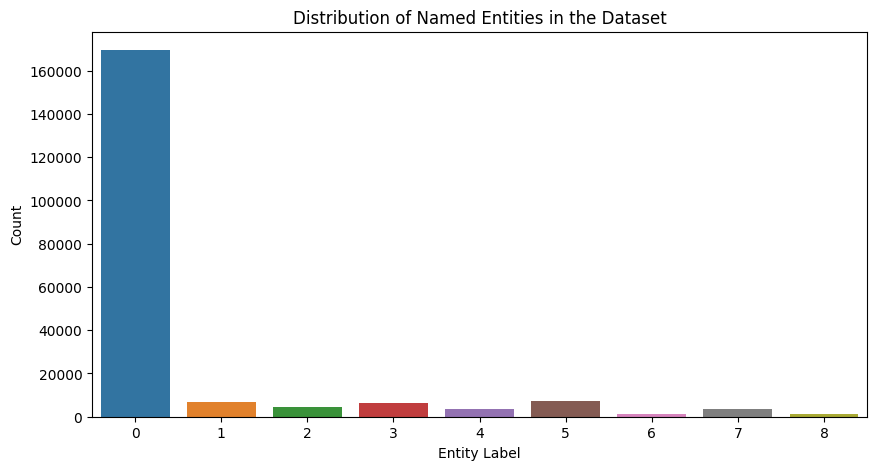

In [5]:
# Check dataset information
print(df_train.info())

# Check for missing values
print(df_train.isnull().sum())

# Check entity distribution
entity_counts = {}
for labels in df_train['ner_tags']:
    for label in labels:
        entity_counts[label] = entity_counts.get(label, 0) + 1

# Plot entity distribution
plt.figure(figsize=(10,5))
sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()))
plt.xlabel("Entity Label")
plt.ylabel("Count")
plt.title("Distribution of Named Entities in the Dataset")
plt.show()


In [6]:
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import AutoModelForTokenClassification, AutoTokenizer, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [7]:
# Load CoNLL-2003 dataset
dataset = load_dataset("conll2003")

# Define label names from dataset
label_names = dataset["train"].features["ner_tags"].feature.names

# Load tokenizer for BERT model (using "bert-base-cased" since it retains case)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


In [8]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding="max_length", is_split_into_words=True)
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to words
        previous_word_id = None
        label_ids = []
        
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)  # Ignore special tokens
            elif word_id != previous_word_id:
                label_ids.append(label[word_id])  # Assign label to first token of word
            else:
                label_ids.append(-100)  # Ignore subword tokens
            
            previous_word_id = word_id

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [9]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [10]:
train_data = tokenized_datasets["train"]
val_data = tokenized_datasets["validation"]

# Define batch collator
data_collator = DataCollatorForTokenClassification(tokenizer)

In [11]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_names))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
training_args = TrainingArguments(
    output_dir="./ner_model",
    evaluation_strategy="epoch",
    save_strategy="no",  # Don't save the model
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
import torch

# Ensure model runs on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir="./ner_model",
    evaluation_strategy="epoch",
    save_strategy="no",  # Don't save the model
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",  # Disable WandB logging
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


<ipython-input-15-8e8a6cdb5aaf>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.044100,0.040805
2,0.021300,0.043620
3,0.004400,0.042589


TrainOutput(global_step=5268, training_loss=0.03365928685450297, metrics={'train_runtime': 2553.8634, 'train_samples_per_second': 16.494, 'train_steps_per_second': 2.063, 'total_flos': 1.1007299854181376e+16, 'train_loss': 0.03365928685450297, 'epoch': 3.0})

In [ ]:
label_names_test = dataset["test"].features["ner_tags"].feature.names

In [ ]:
test_data = tokenized_datasets["test"]

In [ ]:
predictions, labels, _ = trainer.predict(test_data)
preds = np.argmax(predictions, axis=2)

# Convert predictions and labels to actual entity names
true_entities = [[label_names_test[l] for l in label if l != -100] for label in labels]
pred_entities = [[label_names_test[p] for (p, l) in zip(pred, label) if l != -100] for pred, label in zip(preds, labels)]

# Generate evaluation report
print(classification_report(true_entities, pred_entities))
